Dynamics of continental accretion
======

This notebook outlines the Underworld model used in the Moresi (2014) paper 'Dynamics of continental accretion'. It reproduces the initial conditions shown in Extended Data Figure 1 and 2 and the numerics required for reproduce Figure 2.

"In order to better understand the behaviour of this ancient plate mar- gin and the growth of the Australian continent, we use three-dimensional (3D) dynamic models of a subducting slab, overriding plate and mantle, building on previous work14–16. The models have a four-layer subduct- ing plate with buoyancy and rheology of each layer pre-calculated from a half-space cooling model of 80 or 120 Myr age, and they include either a weak or a strong viscoplastic overriding plate (Table 1 and Extended Data Figs 1 and 2). The simulations are best understood by viewing movies of the time evolution (Table 1)."

**References**

Moresi, L., P. G. Betts, M. S. Miller, and R. A. Cayley. 2014. “Dynamics of Continental Accretion.” Nature 508 (7495): 245–48. [doi:10.1038/nature13033](https://www.nature.com/articles/nature13033)

In [1]:
# core UW bit
import UWGeodynamics as GEO
from UWGeodynamics import visualisation as vis
from UWGeodynamics.scaling import units as u
from UWGeodynamics.scaling import dimensionalise
from UWGeodynamics.scaling import non_dimensionalise as nd
from underworld import function as fn

loaded rc file /opt/venv/lib/python3.7/site-packages/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
# 3rd party python modules
import math
import numpy as np
import os
import scipy

In [3]:
import geo_model_properties as modprop
import relrho_geo_material_properties as matprop
import geo_moresi_2014_scaling

In [4]:
# shortcuts for parallel wrappers
barrier = GEO.uw.mpi.barrier
rank    = GEO.rank

In [5]:
# scaling debug check
if rank == 0:
    print(dimensionalise(10.,u.meters)," | ", nd(100.*u.megapascal) )
    #GEO.scaling.get_coefficients()

10000000.0 meter  |  0.125


**Setup parameters**


In [6]:
# elRes = (256,96.96)
elRes = (124, 96)

dim = len(elRes)

checkpoint_restart = False
outputPath = f"output-{elRes[0]}x{elRes[1]}x{elRes[2]}" if dim == 3 else f"output-{elRes[0]}x{elRes[1]}"

In [7]:
outputPath = os.path.join(os.path.abspath("."), outputPath)
if rank==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
barrier()

if checkpoint_restart == True:
    # you need to define these
    outputPath_restart = os.path.join(os.path.abspath("."),"output_checkPoint_restart/")
    time = 4.38067181e+03
    step = 1

**Create mesh and finite element variables**

In [8]:
# Domain
boxLength = modprop.boxLength
boxHeight = modprop.boxHeight
boxWidth  = modprop.boxWidth

In [9]:
# Define our vertical unit vector using a python tuple
if dim == 2:
    minCoord   = (0., -boxHeight)
    maxCoord   = (boxLength, 0.)
    z_hat      = ( 0.0, 1.0)
    
else:
    minCoord   = (0., -boxHeight, 0.)
    maxCoord   = (boxLength, 0., boxWidth)
    z_hat      = ( 0.0, 1.0, 0.0 )
    
Model = GEO.Model(elementRes = elRes,
                  minCoord   = minCoord,
                  maxCoord   = maxCoord,
                  gravity    = z_hat,
                  outputDir  = outputPath)

In [10]:
# Parameters for the inital material layout

# I assume here the origin is a the top, front, middle
# 'middle' being the slab hinge at top, front

pert = 0.3  # nondimensional pert 
slab_xStart = 2500. * u.kilometer
slab_dx = 3000.0 * u.kilometer  # was 7000 km in Moresi 2014
slab_dy =  100.0 * u.kilometer
slab_dz = 3000.0 * u.kilometer # this is the entire domain width
slab_layers = 4

slab_crust = 7.0 * u.kilometer


backarc_dx = 1200. * u.kilometer
backarc_dy =  100. * u.kilometer
backarc_xStart = slab_xStart - backarc_dx
backarc_layers = 2

trans_dx =  350. * u.kilometer
trans_dy =  100. * u.kilometer
trans_xStart = slab_xStart - backarc_dx - trans_dx
trans_layers = 2

craton_dx = 750. * u.kilometer
craton_dy = 150. * u.kilometer
craton_xStart = slab_xStart - backarc_dx - trans_dx - craton_dx
craton_layers = 2

ribbon_dx =  500. * u.kilometer
ribbon_dy =   50. * u.kilometer
ribbon_dz = 1500. * u.kilometer 
ribbon_xStart = slab_xStart + 500. * u.kilometer

bouyStrip_dx = 500. * u.kilometer
bouyStrip_dy =  50. * u.kilometer
bouyStrip_xStart = slab_xStart + slab_dx - bouyStrip_dx

In [11]:
#variables for initialisation of shapes

slab_y1 = -0*nd(slab_crust)
slab_y2 = -1*nd(slab_dy)/slab_layers
slab_y3 = -2*nd(slab_dy)/slab_layers
slab_y4 = -3*nd(slab_dy)/slab_layers

s_y1 = -0*slab_dy # get dimensionality with slab_dy
s_y2 = -1*slab_dy/slab_layers
s_y3 = -2*slab_dy/slab_layers
s_y4 = -3*slab_dy/slab_layers

backarc_dx = 1200. * u.kilometer
backarc_dy =  100. * u.kilometer
backarc_xStart = slab_xStart - backarc_dx
backarc_layers = 2
dpert = dimensionalise(pert, u.km)

backarc_y1 = -0.*nd(backarc_dy)/backarc_layers
backarc_y2 = -1.*nd(backarc_dy)/backarc_layers

trans_y1 = -0.*nd(trans_dy)
trans_y2 = -1.*nd(trans_dy)

crat_y1 = -0.*nd(craton_dy)
crat_y2 = -1.*nd(craton_dy)

In [12]:
# general shape functions
def slabGeo(x, y, dx, dy):
    shape = [ (x,y), (x+dx,y), (x+dx,y-dy), (x,y-dy), (x-dpert,y-dy-dpert), (x-dpert,y-dpert) ]
    return GEO.shapes.Polygon(shape)

def backarcGeo(x, y, dx, dy):
    shape = [ (x,y), (x+dx,y), (x+dx-dy,y-dy), (x,y-dy)]
    return GEO.shapes.Polygon(shape)

In [13]:
#initialising all features as shapes

# define coordinate uw.functions
fn_x = GEO.shapes.fn.input()[0]
fn_y = GEO.shapes.fn.input()[1]
fn_z = GEO.shapes.fn.input()[2]

op1 = slabGeo(slab_xStart, s_y1, slab_dx, slab_dy/slab_layers)
op1_fin = Model.add_material(name="oceanic plate 1", shape=op1)

op2 = slabGeo(slab_xStart, s_y2, slab_dx, slab_dy/slab_layers)
op2_fin = Model.add_material(name = "oceanic plate 2", shape=op2)

op3 = slabGeo(slab_xStart, s_y3, slab_dx, slab_dy/slab_layers)
op3_fin = Model.add_material(name = "oceanic plate 3", shape=op3)

op4 = slabGeo(slab_xStart, s_y4, slab_dx, slab_dy/slab_layers)
op4_fin = Model.add_material(name = "oceanic plate 4", shape=op4)

ba1 = backarcGeo(backarc_xStart, 0.*u.km, backarc_dx, 50.*u.km)
ba1_fin = Model.add_material(name="backArc1", shape=ba1)

ba2 = backarcGeo(backarc_xStart, -50.*u.km, backarc_dx-50*u.km, 50.*u.km)
ba2_fin = Model.add_material(name="backArc2", shape=ba2)


t1 = GEO.shapes.Box(top=Model.top,      bottom=-trans_dy/trans_layers, 
                    minX=trans_xStart, maxX=trans_xStart+trans_dx)
t1_fin = Model.add_material(name="trans1", shape=t1)


t2 = GEO.shapes.Box(top=-trans_dy/trans_layers, bottom=-trans_dy, 
                    minX=trans_xStart, maxX=trans_xStart+trans_dx)
t2_fin = Model.add_material(name="trans2", shape=t2)


c1 = GEO.shapes.Box(top=Model.top,      bottom=-craton_dy/craton_layers, 
                    minX=craton_xStart, maxX=craton_xStart+craton_dx)
c1_fin = Model.add_material(name="craton1", shape=c1)


c2 = GEO.shapes.Box(top=-craton_dy/craton_layers, bottom=-craton_dy,
                    minX=craton_xStart, maxX=craton_xStart+craton_dx)
c2_fin = Model.add_material(name="craton2", shape=c2)


bs = GEO.shapes.Polygon(vertices=[(nd(bouyStrip_xStart), 0.),
                             (nd(bouyStrip_xStart+bouyStrip_dx), 0.),
                             (nd(bouyStrip_xStart+bouyStrip_dx), 0.-nd(bouyStrip_dy)),
                             (nd(bouyStrip_xStart), 0.-nd(bouyStrip_dy))])
bs_fin = Model.add_material(name="buoyStrip", shape=bs)

# always make 2D ribbon shape, if dim == 3 it's overwritten
rib_shape = GEO.shapes.Box(top=0*u.km, bottom=-50*u.km,
                           minX=ribbon_xStart, maxX=ribbon_xStart+ribbon_dx)

if dim == 3:
    # angle we want the ribbon rotated, can be +ve or -ve
    ang = 0
    rad = np.radians(ang)

    # calculated associated half space normals
    nx = -np.cos(rad)
    nz = np.sin(rad)

    # floor
    hsp1 = GEO.shapes.HalfSpace(normal=(0.,-1.,0.), origin=(0, -50*u.km, 0.))
    # front
    hsp2 = GEO.shapes.HalfSpace(normal=(nx, 0, nz), origin=(ribbon_xStart,0.,Model.maxCoord[2]))
    # back
    hsp3 = GEO.shapes.HalfSpace(normal=(-nx, 0, -nz), origin=(ribbon_xStart+ribbon_dx,0.,Model.maxCoord[2]))
    # width
    hsp4 = GEO.shapes.HalfSpace(normal=(0, 0, -1), origin=(0.,0.,ribbon_dz))

    rib_shape = hsp1&hsp2&hsp3&hsp4

rib = Model.add_material(name="ribbon", shape=rib_shape)


op_change = Model.add_material(name="oceanic plate 1 after phase change")

lm = Model.add_material(name="lower mantle", shape= fn_y < nd(-600.0 * 10**3 * u.meter))

added_material_list = [lm, op1_fin, op2_fin, op3_fin, op4_fin, ba1_fin, ba2_fin, t1_fin, 
                       t2_fin, c1_fin, c2_fin, bs_fin, op_change, rib]

In [14]:
figsize=(1000,300)
camera = ['zoom 100']#['rotate x 30']
boundingBox=( minCoord, maxCoord )

materialFilter = Model.materialField > 0


# ERROR with boundaringBox, maybe BUG for Okaluza
# figSwarm = vis.Figure(figsize=figsize, boundingBox=boundingBox )

# swarmPlot = vis.objects.Points(swarm, materialIndex, materialFilter, colours='gray', opacity=0.5, fn_size=2., 
#                                     discrete=True, colourBar=False, )

Fig = vis.Figure(figsize=(1200,400))

# Show single colour
# Fig.Points(Model.swarm, colour='gray', opacity=0.5, discrete=True, 
#            fn_mask=materialFilter, fn_size=2.0, colourBar=False)

# Show all glory
Fig.Points(Model.swarm, fn_colour=Model.materialField, 
           fn_mask=materialFilter, opacity=0.5, fn_size=2.0)

# Save image to disk
# Fig.save("Figure_1.png")

# Rotate camera angle
Fig.script(camera)

# Render in notebook
# Fig.show()

# Fig.window()

'zoom 100'

In [15]:
for i in Model.materials:
    print(i.name)

lower mantle
oceanic plate 1 after phase change
ribbon
buoyStrip
craton2
craton1
trans2
trans1
backArc2
backArc1
oceanic plate 4
oceanic plate 3
oceanic plate 2
oceanic plate 1
Model


In [16]:
#assigning properties (density, viscosity, etc) to shapes.
# N.B. the default material 'Model' is assigned the 'upper mantle' properties

for i in Model.materials:
    for j in matprop.material_list:
        if i.name == j["name"]:
            print(i.name)
            i.density = j["density"]
            i.viscosity = j["viscosity"]
            c0 = j["cohesion"] if j.get('cohesion') else None
            c1 = j["cohesion2"] if j.get('cohesion2') else c0
            if c0 is not None:
                i.plasticity = GEO.VonMises(cohesion = c0, cohesionAfterSoftening = c1)

lower mantle
oceanic plate 1 after phase change
ribbon
buoyStrip
craton2
craton1
trans2
trans1
backArc2
backArc1
oceanic plate 4
oceanic plate 3
oceanic plate 2
oceanic plate 1
Model


**Eclogite transition**

Assume that the oceanic crust transforms instantaneously and completely to eclogite at a depth of 150 km

In [17]:
op1.phase_changes = GEO.PhaseChange((Model.y < nd(-150.*u.kilometers)),
                                          op_change.index)


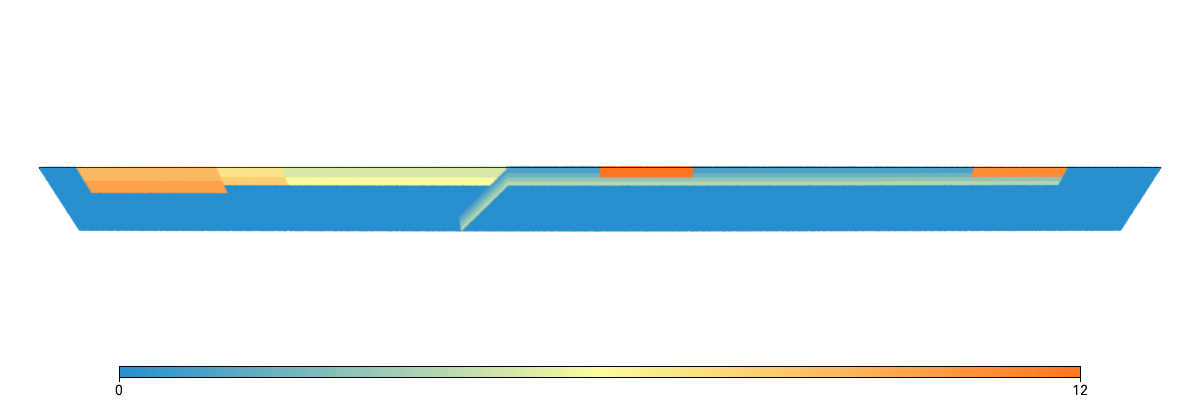

In [18]:
figsize=(1000,300)
camera = ['rotate x 30']
boundingBox=( minCoord, maxCoord )

materialFilter = Model.materialField > -1


# ERROR with boundaringBox, maybe BUG for Okaluza
# figSwarm = vis.Figure(figsize=figsize, boundingBox=boundingBox )

# swarmPlot = vis.objects.Points(swarm, materialIndex, materialFilter, colours='gray', opacity=0.5, fn_size=2., 
#                                     discrete=True, colourBar=False, )

Fig = vis.Figure(figsize=(1200,400))

# Show single colour
# Fig.Points(Model.swarm, colour='gray', opacity=0.5, discrete=True, 
#            fn_mask=materialFilter, fn_size=2.0, colourBar=False)

# Show all glory
Fig.Points(Model.swarm, fn_colour=Model.materialField, 
           fn_mask=materialFilter, opacity=0.5, fn_size=2.0)

# Save image to disk
# Fig.save("Figure_1.png")

# Rotate camera angle
Fig.script(camera)

# Render in notebook
# Fig.show()

In [19]:
# build 3D surface tracers, ie y=0. NOT available for 2D
def tracer_coords(name, minX, maxX, minZ, maxZ):
    
    xx = np.linspace(minX, maxX, max(1, int(maxX-minX))*100)
    yy = np.zeros(1)
    zz = np.linspace(minZ, maxZ, max(1, int(maxX-minX))*100)

    xx, yy, zz = np.meshgrid(xx,yy,zz)
        
    tracers = Model.add_passive_tracers(name,
                                        vertices  = [0.,0.,0.],
                                        centroids = [xx, yy, zz]) 

In [20]:
# Over-riding plate particles
tracer_coords("orp", nd(backarc_xStart),nd(slab_xStart),
              0., nd(boxWidth))
tracer_coords("slab",nd(slab_xStart),nd(bouyStrip_xStart),
              0., nd(slab_dz))
tracer_coords("cont", nd(craton_xStart), nd(backarc_xStart),
              0., nd(boxWidth))
tracer_coords("arc", nd(ribbon_xStart), nd(ribbon_xStart+ribbon_dx),
              nd(ribbon_dz), nd(boxWidth))
tracer_coords("buoy", nd(bouyStrip_xStart), nd(slab_xStart+slab_dx),
              0., nd(slab_dz))

In [21]:
on_grid_x = fn.math.sin(10.*np.pi*Model.x) > 0.9
on_grid_y = fn.math.sin(10.*np.pi*Model.z) > 0.9

grid_conditions = [  
                    ( on_grid_x, 1.),
                    ( on_grid_y, 1.),
                    ( True, -1.),
                  ]

if dim == 3:
    for t in Model.passive_tracers.items():
        new_var = t[1].add_variable(dataType="float", count=1)
        new_var.data[:] = fn.branching.conditional(grid_conditions).evaluate(t[1])

In [22]:
Model.passive_tracers.keys()

odict_keys(['orp', 'slab', 'cont', 'arc', 'buoy'])

In [23]:
FigTracers = vis.Figure(figsize=(1200,400))

# Show single colour
# Fig.Points(Model.swarm, colour='gray', opacity=0.5, discrete=True, 
#            fn_mask=materialFilter, fn_size=2.0, colourBar=False)

# Show all glory
FigTracers.Points(Model.swarm, fn_colour=Model.materialField, 
           fn_mask=materialFilter, opacity=0.5, fn_size=2.0)

def get_show_tracer(name, colours):
    t = Model.passive_tracers.get(name)
    if not t: raise RuntimeError("ERROR: fine tracer called ", name)
    
    FigTracers.Points(t, t.variables[-1],fn_size=2.,
                      colours=colours,opacity=0.5,colourBar=False)
    
if dim == 3:
    
    get_show_tracer(name='orp', colours="#22BBBB #335588")
    get_show_tracer(name='slab', colours="Gray40 Goldenrod")
    get_show_tracer(name='cont', colours="#335588 #22BBBB")
    get_show_tracer(name='arc', colours="Goldenrod Grey41")
    get_show_tracer(name='buoy', colours="#335588 #335588")

# Rotate camera angle
FigTracers.script(camera)

# Render in notebook
# FigTracers.show()

'rotate x 30'

In [24]:
Model.minViscosity = dimensionalise(1., u.Pa * u.sec)
Model.maxViscosity = dimensionalise(1e5, u.Pa * u.sec)

In [25]:
Model.set_velocityBCs( left=[0.,None,None], right=[0.,None,None],
                       bottom=[None,0.,None], top=[None,0.,None],
                       front=[None,None,0.], back=[None,None,0.])

In [26]:
Model.init_model()

In [27]:
# figViscosity = vis.Figure(figsize=figsize, axis=True)
# figViscosity.append( vis.oGEO.rcParams[“default.outputs”]bjects.Points(swarm, viscosityFn, colours='dem1', fn_size=2., logScale=True) )
# if dim == 3:
#     figViscosity.script(camera)
# figViscosity.show()

In [28]:
Fig = vis.Figure(figsize=(1200,400))

# Show all glory
Fig.Points(Model.swarm, fn_colour=Model.densityField, 
           fn_mask=materialFilter, opacity=0.5, fn_size=2.0)

# Rotate camera angle
Fig.script(camera)

# Render in notebook
# Fig.show()

'rotate x 30'

In [29]:
fout = outputPath+'/FrequentOutput.dat'
if rank == 0:
    with open(fout,'a') as f:
         f.write('step\t time(Myr)\t Vrms(cm/yr)\n')
            
def post_solve_hook():
    vrms = Model.stokes_SLE.velocity_rms()
    step = Model.step
    time = Model.time.to(u.megayear)
    
    if rank == 0:
        with open(fout,'a') as f:
             f.write(f"{step}\t{time:5e}\t{vrms:5e}")
        
Model.post_solve_functions["Measurements"] = post_solve_hook

In [30]:
## We can test different solvers by uncommentting this section
# solver = Model.solver
# # System level solver options
# solver.options.main.Q22_pc_type = "uwscale"
# solver.options.main.ksp_k2_type = "GMG"
# solver.options.main.ksp_type    = "bsscr"
# solver.options.main.pc_type     = "none"
# solver.options.main.penalty     = 50.
# #solver.options.main.list()

# # Schur complement solver options
# solver.options.scr.ksp_rtol = 1.0e-3 
# solver.options.scr.ksp_type = "fgmres"
# #solver.options.main.list()

# # Inner solve (velocity), A11 options
# solver.options.A11.ksp_rtol = 1.0e-4
# solver.options.A11.ksp_type = "fgmres"
# #solver.options.A11.list()
# solver.print_petsc_options()

In [31]:
## debugging code to generate initial fields for viscosity and density ##
# fields output used to analyse initial setup

jeta = Model.add_submesh_field(name="cell_vis", nodeDofCount=1)
jrho = Model.add_submesh_field(name="cell_rho", nodeDofCount=1)

GEO.rcParams["default.outputs"].append("cell_vis")
GEO.rcParams["default.outputs"].append("cell_rho")

subMesh = Model.mesh.subMesh
jeta.data[:] = Model._viscosityFn.evaluate(subMesh)
jrho.data[:] = Model._densityFn.evaluate(subMesh)

In [32]:
Model.run_for(nstep=0, checkpoint_interval=1)

Running with UWGeodynamics version 2.9.1
Options:  -Q22_pc_type uw -ksp_type bsscr -pc_type none -ksp_k2_type NULL -rescale_equations False -remove_constant_pressure_null_space False -change_backsolve False -change_A11rhspresolve False -restore_K False -A11_ksp_type fgmres -A11_ksp_rtol 1e-06 -scr_ksp_type fgmres -scr_ksp_rtol 1e-05


1

In [ ]:
# Model.run_for(nstep=1, checkpoint_interval=1)